###Importing necessary libraries

In [21]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

###Data Acquisition

In [22]:
# Choose your stock ticker (e.g., 'TSLA' for Tesla)
ticker = 'TSLA'

# Download historical data (e.g., last 5 years)
data = yf.download(ticker, start='2018-01-01', end='2023-01-01')

# Display the first few rows of data
print(data.head())

[*********************100%***********************]  1 of 1 completed

Price       Adj Close      Close       High        Low       Open     Volume
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA       TSLA
Date                                                                        
2018-01-02  21.368668  21.368668  21.474001  20.733334  20.799999   65283000
2018-01-03  21.150000  21.150000  21.683332  21.036667  21.400000   67822500
2018-01-04  20.974667  20.974667  21.236668  20.378668  20.858000  149194500
2018-01-05  21.105333  21.105333  21.149332  20.799999  21.108000   68868000
2018-01-08  22.427334  22.427334  22.468000  21.033333  21.066668  147891000


###Data Preprocessing

In [23]:
# Handle Missing Values
data.fillna(method='ffill', inplace=True)

# Feature Selection
data_close = data[['Close']]

# Data Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_close)

# Create Sequences for LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(seq_length, len(data)):
        sequences.append(data[i-seq_length:i, 0])  # past 'seq_length' days
        labels.append(data[i, 0])  # next day's closing price
    return np.array(sequences), np.array(labels)

seq_length = 60  # 60 days look-back window
X, y = create_sequences(data_scaled, seq_length)

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to match LSTM input shape (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

<ipython-input-23-3dee2fa16daf>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


###Model Design

In [24]:
# Build LSTM model
model = Sequential()

# Add LSTM layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))  # Dropout for regularization

# Add second LSTM layer
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Output layer (Dense layer)
model.add(Dense(units=1))  # Predict next day's closing price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


###Training and validation

In [25]:
# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 85ms/step - loss: 0.0561 - val_loss: 0.0224
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 0.0033 - val_loss: 0.0042
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0024 - val_loss: 0.0067
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0025 - val_loss: 0.0044
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 0.0021 - val_loss: 0.0036
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0024 - val_loss: 0.0050
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0021 - val_loss: 0.0032
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0

###Evalutation

In [26]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform the predictions and actual values to get the original scale
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate MSE and MAE
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

# Print evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
from sklearn.metrics import r2_score

# Calculate R^2 score
r2 = r2_score(y_test_actual, y_pred_actual)

# Print R^2 value
print(f'R² Score: {r2}')

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step
Mean Squared Error (MSE): 231.32858767067592
Mean Absolute Error (MAE): 12.427378686269124
R² Score: 0.923424829646144


###Visualising the results

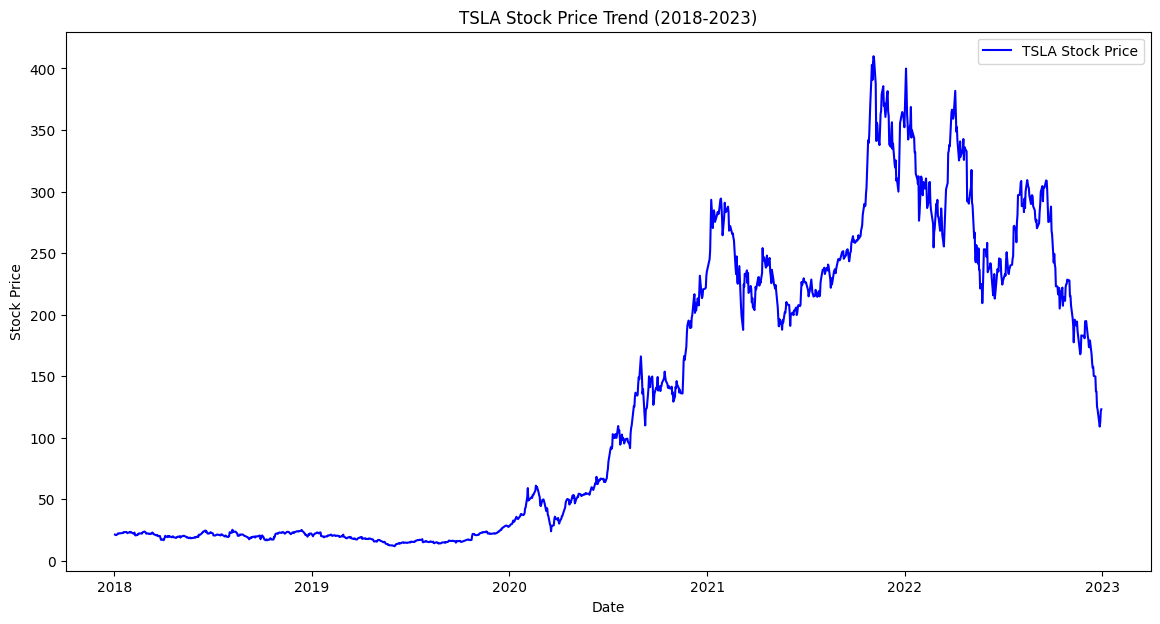

In [27]:
# Plot Data Trends (Stock Price Trend)
plt.figure(figsize=(14,7))
plt.plot(data['Close'], color='blue', label=f'{ticker} Stock Price')
plt.title(f'{ticker} Stock Price Trend (2018-2023)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

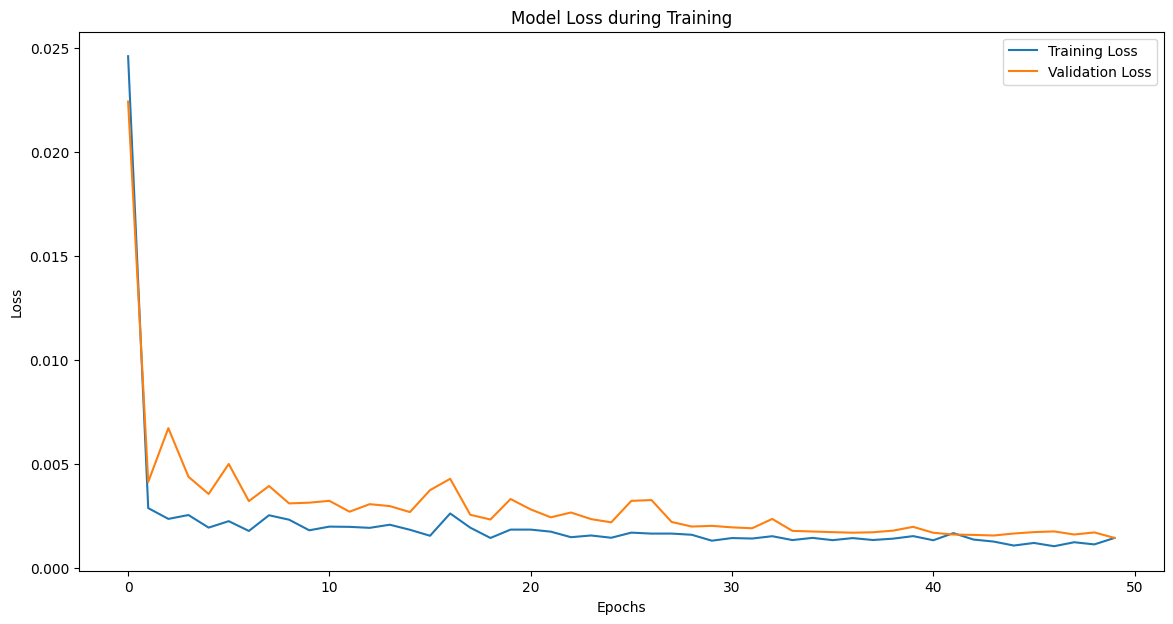

In [28]:
# Plot Training Progress (Loss during Training)
plt.figure(figsize=(14,7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

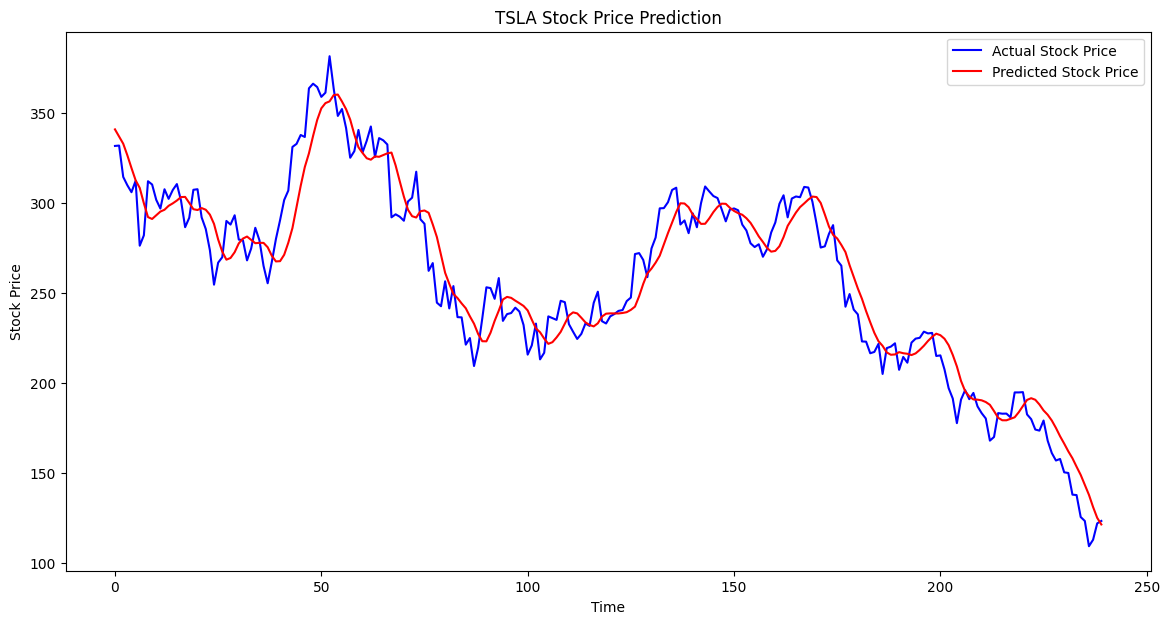

In [29]:
# Plot Predicted vs Actual Prices
plt.figure(figsize=(14,7))
plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(y_pred_actual, color='red', label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()